In [725]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import itertools


In [726]:
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [727]:
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)

In [728]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [729]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [730]:
def update_stim_code(epoch):
    keys_to_delete = [x for x in epoch.event_id if 'stim' in x]
    for key in keys_to_delete:
        if 'stim' in key:
            del epoch.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch.event_id[key] = new_stim_code_event_ids[key]
    
    return epoch
        


In [731]:
epochs = update_stim_code(epoch)
epochs.events.shape

(5424, 3)

Combine 9 events ids into 1 trial

In [732]:
events = epochs.events[:,-1]
event_ids = epochs.event_id

In [669]:
trials = []
nine_epoch = []

for event in events:
    if event == 31 :
        trials.append(nine_epoch)
        nine_epoch = []
        nine_epoch.append(event)
    
    else:
        nine_epoch.append(event)
print(trials[:5])


[[131], [31, 144, 162, 8, 3, 7, 132, 134, 130], [31, 142, 162, 8, 3, 7, 132, 133, 129], [31, 142, 162, 8, 3, 7, 132, 133], [31, 142, 162, 8, 3, 7, 132, 133, 129]]


Add keys for each event ids in trials array

In [670]:
trialsWithKey = []
temp = {}
for eachTrial in trials:
    for eventID in eachTrial:
        for eventName,eventId in event_ids.items():
            if eventID == eventId:
                temp[eventName] = eventID
    trialsWithKey.append(temp)
    temp = {}

del trialsWithKey[0]
trialsWithKey[:3]    

[{'b-f1-pic': 8,
  'b-f2-pic': 7,
  'b-tg-wrd': 3,
  'f_laugh': 162,
  'incongruent': 134,
  'incorrect': 130,
  'right_button': 132,
  't_train': 144,
  'trail_start': 31},
 {'b-f1-pic': 8,
  'b-f2-pic': 7,
  'b-tg-wrd': 3,
  'congruent': 133,
  'correct': 129,
  'f_laugh': 162,
  'right_button': 132,
  't_laugh': 142,
  'trail_start': 31},
 {'b-f1-pic': 8,
  'b-f2-pic': 7,
  'b-tg-wrd': 3,
  'congruent': 133,
  'f_laugh': 162,
  'right_button': 132,
  't_laugh': 142,
  'trail_start': 31}]

Combine epochs in 9 trials 

In [735]:
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
}

In [672]:
trialsWithKey[25]

{'congruent': 133,
 'correct': 129,
 'f-f1-wrd': 14,
 'f-f2-wrd': 13,
 'f-tg-pic': 21,
 'f_water': 165,
 'left_button': 131,
 't_water': 145,
 'trail_start': 31}

In [678]:
#Using the above stim_combinations dict, find stim combinations in each trial and match them to the keys above 
#and use the values as labels to set the key for each trial.
trialsWithStimCombo = []
for trial in trialsWithKey:
    stimComb = []
    for key in trial:
        if trial[key] >= 1 and trial[key] <=24:
            stimComb.append(trial[key])
    
    stimcombo_tuple = (stimComb[0],stimComb[1],stimComb[2])
    stimcomb = []

    try:
        stim_combinations_value = stim_combinations[stimcombo_tuple] 
        dict = {stim_combinations_value : trial}
        trialsWithStimCombo.append(dict)
    except:
        print("stim combination {0} not valid".format(stimcombo_tuple))
        print(trial)
    
    stimcombo_tuple = []
       

In [679]:
trialsWithStimCombo

[{'VVLN': {'b-f1-pic': 8,
   'b-f2-pic': 7,
   'b-tg-wrd': 3,
   'f_laugh': 162,
   'incongruent': 134,
   'incorrect': 130,
   'right_button': 132,
   't_train': 144,
   'trail_start': 31}},
 {'VVLN': {'b-f1-pic': 8,
   'b-f2-pic': 7,
   'b-tg-wrd': 3,
   'congruent': 133,
   'correct': 129,
   'f_laugh': 162,
   'right_button': 132,
   't_laugh': 142,
   'trail_start': 31}},
 {'VVLN': {'b-f1-pic': 8,
   'b-f2-pic': 7,
   'b-tg-wrd': 3,
   'congruent': 133,
   'f_laugh': 162,
   'right_button': 132,
   't_laugh': 142,
   'trail_start': 31}},
 {'VVLN': {'b-f1-pic': 8,
   'b-f2-pic': 7,
   'b-tg-wrd': 3,
   'congruent': 133,
   'correct': 129,
   'f_laugh': 162,
   'right_button': 132,
   't_laugh': 142,
   'trail_start': 31}},
 {'VVLN': {'b-f1-pic': 8,
   'b-f2-pic': 7,
   'b-tg-wrd': 3,
   'f_laugh': 162,
   'incongruent': 134,
   'left_button': 131,
   't_train': 144,
   'trail_start': 31}},
 {'VVLN': {'b-f1-pic': 8,
   'b-f2-pic': 7,
   'b-tg-wrd': 3,
   'congruent': 133,
   'f_laug

Search for VVLN and AALN events and change their event ids.

In [736]:
epochs.events.shape

(5424, 3)

In [737]:
events = epochs.events
events_new = []
temp = []
for event in events:
    
    if event[-1] == 31:
        combo = []
        for trialEpochs in temp:
            if trialEpochs[-1] >=1 and trialEpochs[-1]<=24:
                combo.append(trialEpochs[-1])
        if len(combo) == 3: 
            combo_tuple = (combo[0],combo[1],combo[2]) 
            if stim_combinations[combo_tuple] == "VVLN":
                for k in temp:
                    k[-1] = 100
            elif stim_combinations[combo_tuple] == "AALN":
                for k in temp:
                    k[-1] = 200        
            combo_tuple = []
                
        
        for p in temp:
            events_new.append(p)
        temp = []
        temp.append(event)
    else:
        temp.append(event)

In [738]:
epochs.events.shape

(5424, 3)

In [ ]:
#Select the event 100 or 200 and their data

In [749]:
test = epochs[(epochs.events[:,-1]==100) | (epochs.events[:,-1]==200)]

In [750]:
test.events[:300]

array([[  2580,      0,    100],
       [  2581,     31,    100],
       [  2583,      0,    100],
       [  2593,      0,    100],
       [  2718,      0,    100],
       [  2847,      0,    100],
       [  3200,      0,    100],
       [  3201,    132,    100],
       [  3203,      0,    100],
       [  3669,      0,    100],
       [  3671,      0,    100],
       [  3672,    142,    100],
       [  3682,      0,    100],
       [  3807,      0,    100],
       [  3936,      0,    100],
       [  4298,      0,    100],
       [  4299,    132,    100],
       [  4301,      0,    100],
       [  4487,      0,    100],
       [  4489,      0,    100],
       [  4491,      0,    100],
       [  4500,      0,    100],
       [  4625,      0,    100],
       [  4754,      0,    100],
       [  4792,      0,    100],
       [  4884,      0,    100],
       [  5030,      0,    100],
       [  5032,      0,    100],
       [  5033,    142,    100],
       [  5043,      0,    100],
       [  

In [751]:
#classify using LDA
dataXX = test.get_data()
eventsYY = test.events[:,-1]

clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LDA())

#cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True)
preds = np.empty(len(eventsYY))
scoresss = []
for train,test in cv.split(dataXX,eventsYY):
    clf.fit(dataXX[train],eventsYY[train])
    preds[test] = clf.predict(dataXX[test])
    scoresss.append(clf.score(dataXX[test],eventsYY[test]))

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

In [752]:
print("mean classification score", np.mean(scoresss))

mean classification score 0.6632573585714163


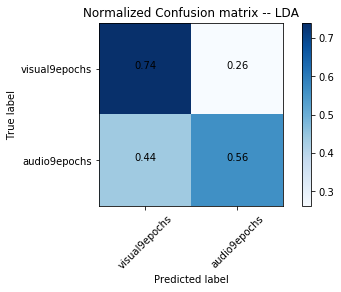

In [753]:
#plot confusion matrix
target_names = [ 'visual9epochs', 'audio9epochs']
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout



cm = confusion_matrix(eventsYY,preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix -- LDA')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

fmt = '.2f'
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j],fmt),
                 horizontalalignment="center",
                 color="black")
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()